# P7 - Convolutional Neural Networks (CNNs)
We have now learned about the Perceptron, Linear and logistic regression, Multi-layer perceptron and backpropagation, Auto-encoders.

In this pratical session about Convolutional Neural Networks (CNNs) we will use the MNIST datasets.

First, we will obtain baselines using a Logistic Regression and a Feed-forward Neural Network.

## 0.0 - Imports
We will need to import some libraries to be used in this session. Libraries include data visualizers ([matplotlib](https://matplotlib.org/)), neural network package ([torch](https://pytorch.org/)), and other helper packages for data handling ([sklearn](https://scikit-learn.org/), [numpy](https://numpy.org/)).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import copy

/home/joaocosta/miniconda3/envs/IST_DL21_Env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, other variable definitions are needed to be set. This includes the size of the dataset we will use, and the configuration of the GPU to be activated:

In [2]:
# Configure Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### 0.1 - Create Dataloaders
#### MNIST dataset
Using torchvision we can easily download and use the MNIST dataset to create our train and validation dataloaders

In [3]:
# Define tranform - Convert data to tensor and normalize using dataset mean and std
# mean and std are computed offline using the training dataset
# tranforms.Normalize expects a value of mean and std per image channel
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

# Download and create MNIST train and validation dataloaders
mnist_train_dataset = datasets.MNIST('../data', download=True, train=True, transform=mnist_transform)
mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform)
mnist_train_dataloader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_val_dataloader = DataLoader(mnist_val_dataset, batch_size=64, shuffle=True)

# MNIST Dataloaders to get data into numpy for Logistic Regression
mnist_train_dataloader_numpy = DataLoader(mnist_train_dataset, batch_size=len(mnist_train_dataset))
mnist_val_dataloader_numpy = DataLoader(mnist_val_dataset, batch_size=len(mnist_val_dataset))
X_y_train = next(iter(mnist_train_dataloader_numpy))
X_y_val = next(iter(mnist_val_dataloader_numpy))
X_train = X_y_train[0].numpy()
y_train = X_y_train[1].numpy()
X_val = X_y_val[0].numpy()
y_val = X_y_val[1].numpy()

dataloaders = dict(train=mnist_train_dataloader, val=mnist_val_dataloader)


We can check the MNIST dataset properties such as:

- shape of train and validation datasets - \[number of samples, width, height\]
- number of input feature on the flattened/reshaped input for Logistic Regression or MLP
- shape of train and validation batches - \[batch size, number of channels, width, height\]

In [4]:
# get batch to extract properties and plot example images
# next(enumerator(dataloader)) -> creates an iterator of the dataloader and gets the next batchß
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_train_dataloader))
# info about the dataset
D_in = np.prod(example_imgs.shape[1:])
D_out = len(mnist_train_dataloader.dataset.targets.unique())
print("Datasets shapes:", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})
print("N input features:", D_in, "Output classes:", D_out)
print("Train batch:", example_imgs.shape, example_targets.shape)
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_val_dataloader))
print("Val batch:", example_imgs.shape, example_targets.shape)

Datasets shapes: {'train': torch.Size([60000, 28, 28]), 'val': torch.Size([10000, 28, 28])}
N input features: 784 Output classes: 10
Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Val batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


We can plot some examples with corresponding labels using the following function. This function can also receive the predicted labels.

/tmp/ipykernel_18328/1532427253.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


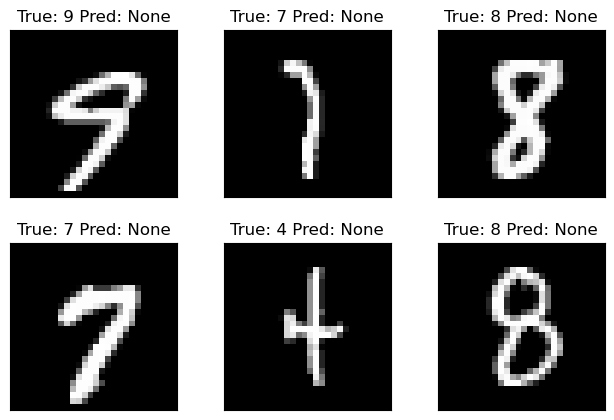

In [5]:
def plot_img_label_prediction(imgs, y_true, y_pred=None, shape=(2, 3)):
    y_pred = [None] * len(y_true) if y_pred is None else y_pred
    fig = plt.figure()
    for i in range(np.prod(shape)):
        plt.subplot(*shape, i+1)
        plt.tight_layout()
        plt.imshow(imgs[i][0], cmap='gray', interpolation='none')
        plt.title("True: {} Pred: {}".format(y_true[i], y_pred[i]))
        plt.xticks([])
        plt.yticks([])

plot_img_label_prediction(imgs=example_imgs, y_true=example_targets, y_pred=None, shape=(2, 3))


## Question 3.1.1
### Logistic Regression

We can use a very simple Logistic Regression that receives our input images as a vector and predicts the digit. This will be our first baseline to compare with the CNNs.

In [6]:
# Use standard scaler to transform input data
scaler = StandardScaler()
X_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
X_val = scaler.transform(np.reshape(X_val, (X_val.shape[0], -1)))

# Use scikit-learn Logistic Regression with C=50., multi_class='multinomial', solver='sag', tol=0.1
clf = LogisticRegression(C=50., multi_class='multinomial', solver='sag', tol=0.1)
clf.fit(X_train, y_train)
score = clf.score(X_val, y_val)

print("Test score with penalty: %.4f" % score)

Test score with penalty: 0.9002


We can select the coefficients for each class and reshape them into the image shape to plot them. This allows us to visualize what are the pixels that are contributing more to the classification for each of the digits.

But what happens if the digits are not centered? Will we still get such a good performance? Lets test that out later!

## Question 3.1.2
### Feed-Forward Neural Network

The first step is to create the functions that will allow us to implement a feed-forward neural network and manage the training and validation process.

The MLP class will define the architecture of a feed-forward neural network, with a set of hidden layers (fully connected layers [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)), with a activation function in between them ([relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu)), and a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax) in the last layer. Since the dataset poses a multiclass classification problem, the last layer should have a number of neurons equal to the number of classes.

In [7]:
class MLP(nn.Module):
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        # define layers
        self.dim_layers = dim_layers
        layer_list = [nn.Linear(dim_layers[l], dim_layers[l+1]) for l in range(len(dim_layers) - 1)]
        self.lin_layers = nn.ModuleList(layer_list)

    def forward(self, X):
        # reshape X
        X = X.view(-1, self.dim_layers[0])
        # apply relu
        for layer in self.lin_layers[:-1]:
            X = F.relu(layer(X))
        # use softmax for output layer
        return F.log_softmax(self.lin_layers[-1](X), dim=1)

##### training validation function for the MLP and CNN

In [8]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # init dictionaries to save losses and accuracies of training and validation
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # execute a training and validation phase for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to train mode
            else:
                model.eval()   # Set model to eval mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # set the parameter gradients to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # if in training phase, perform backward prop and optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # increment loss and correct counts
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))

    # load best model weights to return
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

We will start by creating a simple network with some hidden layers. Thus, in addition to the input, it will have 3 fully connected layer which, in this implemetation, is assigned to the input of the MLP Class. We will use the Stochastic Gradient Descend optimizer ([optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) with 0.01 learning rate and 0.5 momentum. The loss function to be optimized will be negative log likelihood ([nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). Training and validation will be managed by the function "train_val_model" previously define.

Epoch 0/14
----------
train Loss: 0.7394 Acc: 79.36%
val Loss: 0.2988 Acc: 91.10%

Epoch 2/14
----------
train Loss: 0.1748 Acc: 94.87%
val Loss: 0.1457 Acc: 95.63%

Epoch 4/14
----------
train Loss: 0.1078 Acc: 96.84%
val Loss: 0.1025 Acc: 96.73%

Epoch 6/14
----------
train Loss: 0.0734 Acc: 97.83%
val Loss: 0.0897 Acc: 97.07%

Epoch 8/14
----------
train Loss: 0.0522 Acc: 98.50%
val Loss: 0.0843 Acc: 97.40%

Epoch 10/14
----------
train Loss: 0.0383 Acc: 98.92%
val Loss: 0.0720 Acc: 97.77%

Epoch 12/14
----------
train Loss: 0.0275 Acc: 99.24%
val Loss: 0.0683 Acc: 97.87%

Epoch 14/14
----------
train Loss: 0.0198 Acc: 99.51%
val Loss: 0.0709 Acc: 97.83%

Training complete in 3m 7s
Best val Acc: 97.94%


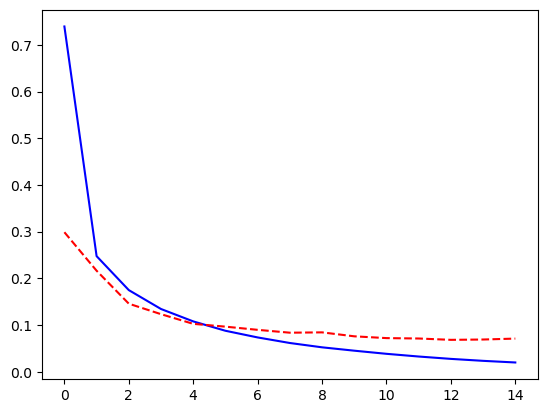

In [9]:
# instantiate model
model_mlp = MLP([D_in, 256, 128, 64, D_out]).to(device)

# instantiate optimizer and criterion
optimizer = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

# train and validate model
model_mlp, losses, accuracies = train_val_model(model_mlp, criterion, optimizer, dataloaders,
                       num_epochs=15, log_interval=2)

# plot losses
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

## Question 3.1.3
### Plots of the coefficients of the Logistic Regression for each class

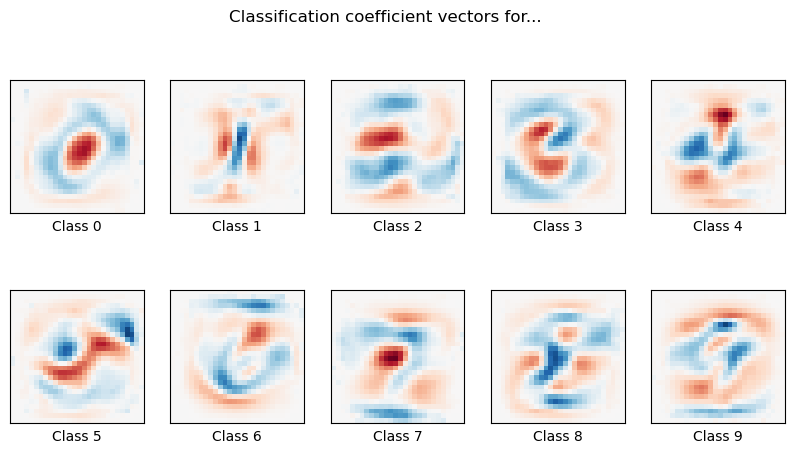

In [10]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    # iterate over the classes and reshape coefficients to ensure proper visualization
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification coefficient vectors for...')

plt.show()